In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyscipopt import Model, quicksum
from tabulate import tabulate

In [2]:
M = 50
NumExpert = 3

In [3]:
rnd = np.random.RandomState(1)

In [4]:
matrix = rnd.normal(10, 1, size=(M, 3))

In [5]:
a_prim = np.zeros((NumExpert,M,M))
for k in range(NumExpert):
    for i in range(M):
        for j in range(M):
            if matrix[i,k] < matrix[j,k]:
                a_prim[k,i,j] = 0
            else:
                a_prim[k,i,j] = 1

In [6]:
a = np.round(a_prim + rnd.normal(0, 0.1, (NumExpert,M,M)),2)

In [7]:
a[ a < 0.00001 ] = 0.0
a[ a > 0.99999 ] = 1.0
for k in range(NumExpert):
    for i in range(M):
        a[k,i,i] = 1
    print(f"k = {k}")
    print(tabulate(a[k], numalign="right"), "\n")

k = 0
----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
   1  0.76   0.1     1     1  0.99  0.99  0.99     1  0.89  0.95   0.9     1  0.97     1  0.98     1     1     1  0.81  0.94     1     1  0.98     1  0.98     1  0.97     1  0.97  0.87     1     1     1  0.99  0.94     1     1     1  0.99     1  0.04  0.19     1     1  0.84     1     1     1     1
   0     1     0   0.2     0  0.82     0     0     0   0.2     0     0     1     0     0  0.09  0.06     0  0.14  0.01  0.16  0.05  0.16     1     0     1     0     0     0     0  0.02  0.02  0.07  0.18     0     0     0     0     0     1     0     0     0     0  0.91  0.07  0.06     0  0.18     0
0.97  0.98     1     1     1   0.9     1     1     1  0.94     1  0.85     1  0.96     1     1   

In [135]:
def kemeny_matrix(a):
    w = np.zeros((M,M))
    for k in range(NumExpert):
        for i in range(M):
            for j in range(M):
                if a[k,j,i] > 0 and i != j:
                    w[i,j] += 1
    model = Model() 
    model.hideOutput(True)
    x = {}
    for i in range(M):
        for j in range(M):
            if i != j:
                x[(i,j)] = model.addVar(f"x[{i},{j}]", vtype = 'B')
    for l in range(M):
        for i in range(M):
            for j in range(M):
                if i != j and j != l and i != l:
                    model.addCons(x[(i,j)] + x[(j,l)] + x[(l,i)] >= 1)
    for i in range(M):
        for j in range(M):
            if i != j:
                model.addCons(x[(i,j)] + x[(j,i)] == 1)
    model.setObjective(quicksum(w[i,j] * x[(i,j)] for i in range(M) for j in range(M) if i != j), "minimize")
    model.optimize()
    sol = model.getBestSol()
    if model.getStatus() != 'optimal':
        print(f"Ops! {model.getStatus()}")
        return np.zeros((M,M))
    print('SolvingTime = ',model.getSolvingTime())
    return np.array([[ int(round(sol[x[(i,j)]],0)) if i != j else 1 for j in range(M)] for i in range(M)])

In [57]:
kms = []
tetas = []
for teta in np.arange(0.1,1.1,0.1):
    print("teta = ",teta)
    tetas.append(teta)
    a_teta = np.array(a)
    a_teta[a_teta >= teta] = 1
    a_teta[a_teta < 1] = 0
    mykm = kemeny_matrix(a_teta)
    kms.append(mykm)

0.1
0.62519
0.2
0.7611709999999999
0.30000000000000004
5.359843
0.4
3.5913370000000002
0.5
3.583044
0.6
3.629458
0.7000000000000001
2.437614
0.8
5.416053
0.9
0.521592
1.0
2.233422


In [133]:
for i in range(len(kms)-1):
    print(i, round(tetas[i],2),round(tetas[i+1],2),len(np.where(kms[i] != kms[i+1])[0]))

0 0.1 0.2 184
1 0.2 0.3 154
2 0.3 0.4 60
3 0.4 0.5 0
4 0.5 0.6 0
5 0.6 0.7 74
6 0.7 0.8 112
7 0.8 0.9 166
8 0.9 1.0 326


In [136]:
kms_prim = kemeny_matrix(a_prim)

SolvingTime =  3.582861


In [143]:
for i in range(len(kms)):
    print(i, round(tetas[i],2), np.sum(np.abs(kms_prim - kms[i])))

0 0.1 126
1 0.2 114
2 0.3 60
3 0.4 0
4 0.5 0
5 0.6 0
6 0.7 74
7 0.8 154
8 0.9 148
9 1.0 346


In [125]:
res_fuzzy_matrix = np.eye(M,M)
for i in range(M):
    for j in range(M):
        if i !=j:
            ind = np.nonzero(np.fromiter((kms[k][i,j] for k in range(len(tetas))), int))[0]
            if len(ind) > 0:
                res_fuzzy_matrix[i,j] = tetas[np.max(ind)]

In [128]:
print(tabulate(res_fuzzy_matrix))

---  -  ---  ---  ---  ---  ---  ---  ---  ---  -  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  -  -  ---  -  ---  ---  ---  -  ---  ---  ---  -  ---  ---  ---  ---  ---  ---  ---  -  ---  ---  ---  -  ---  -  ---  ---
1    1  1    1    1    1    1    0    1    1    1  1    1    1    1    0    1    1    1    0    0    1    0  1  1    1  1    1    1    1  0    1    1    0  1    1    1    1    1    0    1    0  1    1    1    1  1    1  1    0
0    1  0    0    0    0.9  0    0    0    0    0  0    0    0    0    0    0    0    0    0    0    0    0  1  0    0  0    0    0    0  0    0    0    0  0    0    0    0    0    0    0    0  0    0    0    0  0    0  0    0
0.9  1  1    1    1    1    1    0    1    1    1  1    1    1    1    0.9  1    1    1    0    0    1    0  1  1    1  1    1    1    1  0.9  1    1    0  1    1    1    1    1    0    1    0  1    1    1    1  1    1  1    0
0    1  0    1    0.9  1    0.1  0    0    1    1  1    0    0    0    0    0    1    0   

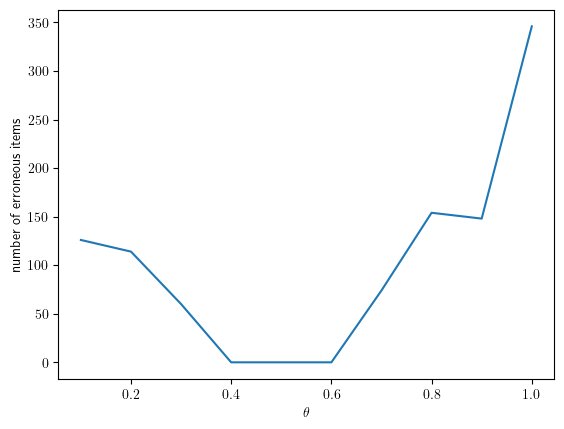

In [10]:
plt.rcParams['text.usetex'] = True
ax = plt.subplot(1,1,1)
ax.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
[126,114,60,0,0,0,74,154,148,346])
ax.set_ylabel('number of erroneous items')
ax.set_xlabel('$\\theta$')
plt.savefig("fig_prec.png", dpi=600)
plt.show()

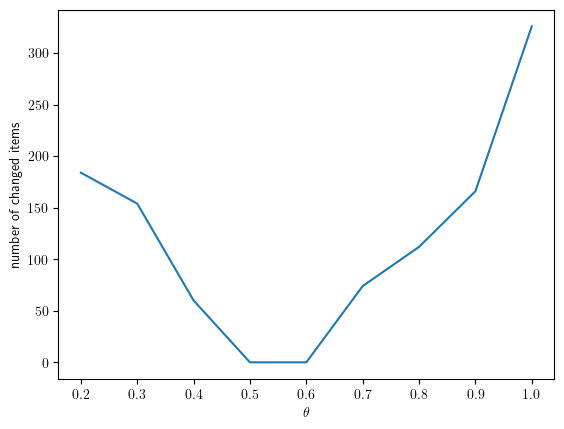

In [11]:
plt.rcParams['text.usetex'] = True
ax = plt.subplot(1,1,1)
ax.plot([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
[184,154,60,0,0,74,112,166,326])
ax.set_ylabel('number of changed items')
ax.set_xlabel('$\\theta$')
plt.savefig("fig_ch.png", dpi=600)
plt.show()